<a href="https://colab.research.google.com/github/TakafumiMatsuda/Python-Training/blob/master/GradCam1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#https://qiita.com/sasayabaku/items/fd8923cf0e769104cc95
#初心者のGradCAM | CNNの視覚化

import pandas as pd
import numpy as np
import os

import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR

from torchvision.datasets import CIFAR10 
import torchvision.transforms as transforms
#from model import CNNModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
#ハイパーパラメータ
cifar_data_root = './data'
batch_size = 50
epochs = 5

In [0]:
###データ準備
#Transform定義
transform = transforms.Compose(
    [transforms.ToTensor      (),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5 ))]
)
train_data = CIFAR10(root=cifar_data_root, download=True, train=True, transform=transform) 
test_data = CIFAR10(root=cifar_data_root, download=True, train=False, transform=transform) 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
###モデル定義
###★★improveNet1★★###
import torch.nn as nn
import torch.nn.functional as F

#画像は3チャネル(RGB)×32ピクセル×32ピクセル　※3チャネル: 元の画像を光の三原色に分解
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0)  
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #MAXプーリング層
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #MAXプーリング層
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0) 
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1) #MAXプーリング層
        ######self.view = np.view(self.size(0), -1) #★失敗
        #self.pool2 = nn.AvgPool2d(kernel_size=3) #GlobalAveragePooling
        self.fc1 = nn.Linear(128 * 3 * 3, 120) #[512, 120]
        self.fc2 = nn.Linear(120, 10) #10クラス #出力層

    def forward(self, x):
        #print(x.shape) #[50, 3, 32, 32](ker=3) [bachsize, channel, 32*32]
        x = self.pool1(F.relu(self.conv1(x))) #convで32→30、poolで30→15(ker=3)　
        #print(x.shape) #[50, 64, 15, 15](ker=3)
        x = self.pool2(F.relu(self.conv2(x))) #convで15→13、poolで13→6
        #print(x.shape) #[50, 128, 6, 6](ker=3)
        x = self.pool3(F.relu(self.conv3(x))) #convで6→4、poolで4→2
        #print(x.shape) #[50, 128, 2, 2]　←☆CAMを行うためにはここで画像サイズが1,1になっている(GlobalAveragePooling)ことが必要
        #print('--------')
        #x = x.view(-1, 128 * 2 * 2)
        x = x.view(x.size(0), -1) #4次元(batch, 直前のoutputチャネル数, kernel, kernel)のデータを2次元(batch, output*out*ker*ker)にして全結合層に渡す
        #print(x.shape) #[50, 512]
        
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #print(x.shape) #[50, 120]

        x = self.fc2(x)
        #print(x.shape) #[50, (1, 1,) 10] (ker=5)

        return x

net = Net()
net.to(device) #GPUに渡す

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [0]:
model = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
schedular = ExponentialLR(optimizer, gamma=0.95)

In [0]:
###学習
for epoch in range(epochs):
    
    schedular.step()
    
    epoch_loss =  0
    correct = 0
    total = 0
    for i, samples in enumerate(train_loader):
        data, labels = samples
        
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = criterion(outputs, labels) 
        epoch_loss += loss.item()
        
        predicted = outputs.max(1, keepdim=True)[1]
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        total += labels.size(0)
        
        loss.backward()
        optimizer.step()
    print('{} epoch: Loss {}, Accuracy {}'.format((epoch+1),
                               epoch_loss / len(train_loader),
                               correct / total
                               ))
    

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


1 epoch: Loss 1.7809701092243195, Accuracy 0.34028
2 epoch: Loss 1.605231929898262, Accuracy 0.41026
3 epoch: Loss 1.5686793940067292, Accuracy 0.426
4 epoch: Loss 1.5375849734544753, Accuracy 0.43786
5 epoch: Loss 1.5080163995027542, Accuracy 0.45146


In [0]:
###Grad-CAMによる可視化
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys

#Flattenの実装(PyTorchには，多次元配列を1次元の配列に変換する．Flattenがないので実装)
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)

#特徴設計部の最終出力 & 識別部の出力を取得
feature_fn = torch.nn.Sequential(*list(model.children())[:-2]).to(device) #Sequentialにリストを渡してやる
#print(list(model.children())[:-2]) #[:-2]: リストの最後の2つのを除いた要素（MaxPoolまで）
#print(list(model.children())) 
#print(list(model.children())[:-1])
print(feature_fn) 

classfier_fn = torch.nn.Sequential(*(list(model.children())[-2:-1] + [Flatten()]
                                    + list(model.children())[-1:]
                                    )).to(device)
#print(list(model.children())[-2:-1]) #512*120
#print([Flatten()])
#print(list(model.children())[-1:])
print(classfier_fn) 

#GradCAM
def GradCam(img, c, feature_fn, classifier_fn): #(input, class label, 特徴量層, 全結合層)
    #print('img = ',img.shape) #torch.Size([1, 3, 32, 32])
    feats = feature_fn(img.to(device)) #img
    _, N, H, W = feats.size()
    #print(feats)
    #print(feats.size()) #torch.Size([1, 128, 13, 13]) = print(feats.shape)　★ここが[1, 128 , 2, 2]になってないとおかしい！！
    #print(feats.size(0)) #1
    #print(feats.view(feats.size(0))) #shape '[1]' is invalid for input of size 21632
    #print(feats.view(feats.size(0), -1)) #tensor([[-70.0952, -72.0486, -69.8751,  ..., -74.4457, -74.7196, -76.3472]], device='cuda:0', grad_fn=<ViewBackward>)
    #view: 4次元(1, 直前のoutputチャネル数, kernel, kernel)のデータを2次元(batch, output*out*ker*ker)に [1, 128*13*13]=[1, 21632]
    out = classifier_fn(feats.view(feats.size(0), -1))
    c_score = out[0, c]
    print(c_score)
    grads = torch.autograd.grad(c_score, feats) #(input, output): inputに対するoutputの勾配の合計
    print(grads)
    w = grads[0][0].mean(-1).mean(-1) #全ピクセルについて平均
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = F.relu(sal) #Reluを行う
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0)
    return sal, out, c_score, feats, grads, w

#全結合層では画像の位置に関連した情報を完全に失ってしまう。一方、入力に近いところでは抽象度の低い認識しか行われない。
#CNNの部分の最終（全結合層の入力に当たる部分）に双方を満たす情報がある

###Grand-CAM###
#クラスごとの確率スコアへの影響が大きい画像箇所を微分係数（特徴量マップ*においてある画像箇所に微小変化を加えたときに確率スコアに生じる変化の大きさを表す係数）の平均化によって特定する
#出力対象クラス以外の勾配を0にセットして対象クラスのみを1に設定する。
#★前提となるアイディア：クラス判定に与える影響が大きい画像箇所は、確率スコアの微分係数も大きい！

###CAMの欠点###
#ネットワークの全結合層がGlobal Average Pooling(画像サイズが(1*1)になるプーリング)層に置き換わってなくてはならない。conv->global average->softmax
#また最終層ではチャネル数 = クラス数となっている必要あり



#*入力画像をCNNの特徴抽出器（全結合層より前の部分）に通して得られる特徴量を画像として出力した2次元マップ

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (0): Linear(in_features=1152, out_features=120, bias=True)
  (1): Flatten()
  (2): Linear(in_features=120, out_features=10, bias=True)
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(6277.3975, device='cuda:0', grad_fn=<SelectBackward>)
(tensor([[[[ 0.3545,  0.2361,  0.2792],
          [ 0.2153,  0.3125,  0.2968],
          [ 0.1083,  0.0903,  0.0377]],

         [[ 0.3121,  0.4373,  0.6679],
          [ 0.4953,  0.4055,  0.3506],
          [ 0.3427,  0.3092,  0.2812]],

         [[ 0.0913,  0.1146, -0.0196],
          [ 0.0692,  0.0960, -0.0041],
          [ 0.0201, -0.0404,  0.0864]],

         ...,

         [[ 0.2001,  0.0173, -0.1040],
          [-0.0079,  0.1449,  0.2248],
          [-0.2641, -0.0076,  0.3195]],

         [[ 0.1612, -0.8022, -1.2881],
          [ 0.4336,  0.0470, -0.1490],
          [ 0.0137, -0.6759,  0.1796]],

         [[-0.0406, -0.0379, -0.0991],
          [ 0.0180,  0.0221, -0.0284],
          [ 0.0546,  0.0481, -0.1114]]]], device='cuda:0'),)


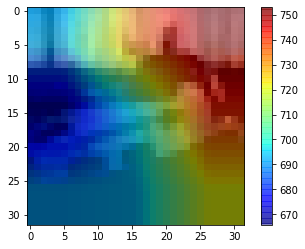

In [0]:
###GradCAMの実行
#対象画像の取得
input_index = 2
input_data = test_loader.dataset[input_index][0]
#print(len(input_data)) #3
input_data = input_data.view(1, input_data.shape[0], input_data.shape[1], input_data.shape[2]).to(device)
#print(input_data.shape[0])
#print(input_data.shape[1])
#print(input_data.shape[2])
#print(input_data.__getitem__(0)[0].shape) #[32, 32]
#print(len(input_data)) #1

#上位2クラスの識別部の出力 & クラスラベルを取得
pp, cc = torch.topk(nn.Softmax(dim=1)(model(input_data)), 2) 
#topk()は，上位kクラスのデータとクラスラベルを取得する関数
#pp → CNNモデルの出力層の出力
#cc → それに対応するクラスラベル

#print(pp) #[[0.1103, 0.1036]]
#print(cc) #5,3
#print(cc[0])
#print(cc[0][0]) #5

#saliency mapの取得
sal, out, c_score, feats, grads, w = GradCam(input_data, cc[0][0], feature_fn, classfier_fn)
#sal → cc[0][0]で指定したクラスラベルにおける勾配のSaliency Map
#cc[0][0]

#取得したSaliency Mapを画像化
img = input_data.permute(0, 2, 3, 1).view(input_data.shape[2], input_data.shape[3], input_data.shape[1]).cpu().numpy()
img_sal = Image.fromarray(sal).resize(img.shape[0:2], resample=Image.LINEAR)

#表示
plt.imshow(img)
plt.imshow(np.array(img_sal), alpha=0.5, cmap="jet")
plt.colorbar()


#内積をとる行列のサイズが不正な場合: RuntimeError: size mismatch, m1: [1*21632]実際の入力　入力, m2: [512 x 120]定義した入力
#self.fc1 = nn.Linear(128 * 2 * 2, 120) と定義した
##########classiferのinputは512*120
#Sequential((0): Linear(in_features=512, out_features=120, bias=True)
#           (1): Flatten()
#           (2): Linear(in_features=120, out_features=10, bias=True))
#########
#RuntimeError: non-empty 3D or 4D (batch mode) tensor expected for input

In [0]:
#動かなかったやつ
###モデル定義（動かない…）
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=3)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=3)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=5)
        self.pool3 = nn.MaxPool2d(kernel_size=3)
        self.fc1 = nn.Linear(90, 2000)
        self.fc2 = nn.Linear(2000, 10)

    def forward(self, x):
        out = self.pool1(F.relu(self.conv1(x)))
        out = self.pool2(F.relu(self.conv2(out)))
        out = self.pool3(F.relu(self.conv3(out)))
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out

net = Net()
net.to(device) #GPUに渡す

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)